In [17]:
# Copyright (c) OpenMMLab. All rights reserved.
import mmcv
import numpy as np
import torch
from collections import OrderedDict
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt

def intersect_and_union(pred_label,
                        label,
                        num_classes,
                        ignore_index,
                        label_map=dict(),
                        reduce_zero_label=False,
                        int16=False):
    if isinstance(pred_label, str):
        pred_label = torch.from_numpy(np.array(Image.open(pred_label)))
        # pred_label = torch.from_numpy(np.load(pred_label))
    else:
        pred_label = torch.from_numpy((pred_label))

    if isinstance(label, str):
        label = torch.from_numpy(
            mmcv.imread(label, flag='unchanged', backend='pillow'))
    else:
        label = torch.from_numpy(label)

    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect = torch.histc(
        intersect.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_pred_label = torch.histc(
        pred_label.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_label = torch.histc(
        label.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_union = area_pred_label + area_label - area_intersect
    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(results,
                              gt_seg_maps,
                              num_classes,
                              ignore_index,
                              label_map=dict(),
                              reduce_zero_label=False,
                              int16=False):
    total_area_intersect = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_union = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_pred_label = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_label = torch.zeros((num_classes, ), dtype=torch.float64)
    for result, gt_seg_map in zip(results, gt_seg_maps):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(
                result, gt_seg_map, num_classes, ignore_index,
                label_map, reduce_zero_label, int16)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label


def mean_iou(results,
             gt_seg_maps,
             num_classes,
             ignore_index,
             nan_to_num=None,
             label_map=dict(),
             reduce_zero_label=False,
             int16=False):
    iou_result = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mIoU'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label,
        int16=int16)
    return iou_result


def total_area_to_metrics(total_area_intersect,
                          total_area_union,
                          total_area_pred_label,
                          total_area_label,
                          metrics=['mIoU'],
                          nan_to_num=None,
                          beta=1):
    if isinstance(metrics, str):
        metrics = [metrics]
    allowed_metrics = ['mIoU', 'mDice', 'mFscore']
    if not set(metrics).issubset(set(allowed_metrics)):
        raise KeyError('metrics {} is not supported'.format(metrics))

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    ret_metrics = OrderedDict({'aAcc': all_acc})
    for metric in metrics:
        iou = total_area_intersect / total_area_union
        acc = total_area_intersect / total_area_label
        ret_metrics['IoU'] = iou
        ret_metrics['Acc'] = acc
    
    ret_metrics = {
        metric: value.numpy()
        for metric, value in ret_metrics.items()
    }
    if nan_to_num is not None:
        ret_metrics = OrderedDict({
            metric: np.nan_to_num(metric_value, nan=nan_to_num)
            for metric, metric_value in ret_metrics.items()
        })
    ious = ret_metrics["IoU"]
    return np.mean(ious[~np.isnan(ious)])


def eval_metrics(results,
                 gt_seg_maps,
                 num_classes,
                 ignore_index,
                 metrics=['mIoU'],
                 nan_to_num=None,
                 label_map=dict(),
                 reduce_zero_label=False,
                 int16=False,
                 beta=1):

    total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label = total_intersect_and_union(
            results, gt_seg_maps, num_classes, ignore_index, label_map,
            reduce_zero_label, int16)
    ret_metrics = total_area_to_metrics(total_area_intersect, total_area_union,
                                        total_area_pred_label,
                                        total_area_label, metrics, nan_to_num,
                                        beta)
    return ret_metrics

In [1]:
# files = glob("../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred/*.png")
# image_ious = {}
# for f in files:
#     name = os.path.basename(f).rstrip(".png")
#     miou = eval_metrics(
#         [f"../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred/{name}.png"], 
#         [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
#         150, 255
#     )
#     image_ious[name] = miou
# import json
# json.dump(image_ious, open("visualization/image_miou_a150.json", "w"))
import json
image_ious = json.load(open("visualization/image_miou_a150.json"))

In [2]:
# files = glob("../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred_c171/*.png")
# image_ious = {}
# from tqdm import tqdm
# for f in tqdm(files):
#     name = os.path.basename(f).rstrip(".png")
#     miou = eval_metrics(
#         [f"../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred_c171/{name}.png"], 
#         [f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/annotations/val2017/{name}_labelTrainIds.png'],
#         171, 255,
#         reduce_zero_label=True
#     )
#     image_ious[name] = miou

In [3]:
# import json
# json.dump(image_ious, open("visualization/image_miou_c171.json", "w"))

ADE_val_00001518 ['coffee table', 'cushion', 'sofa', 'painting.png'] 0.4607465851463033


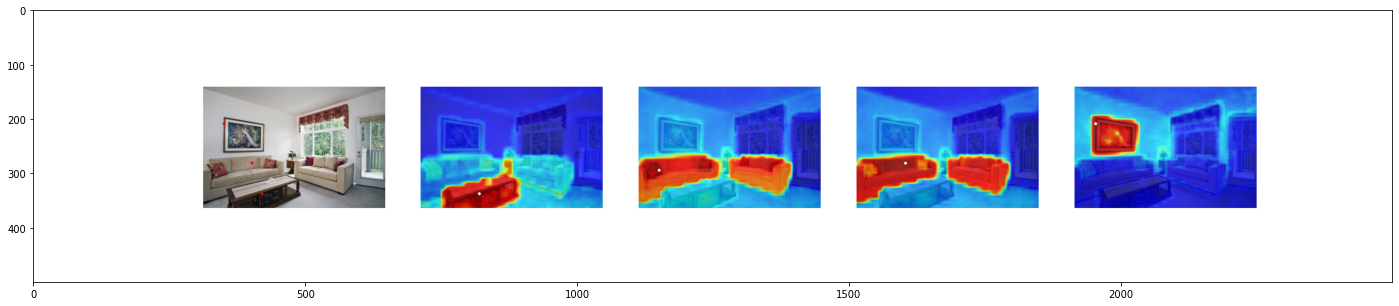

ADE_val_00000512 ['coffee table', 'fireplace', 'sofa', 'lamp', 'cushion', 'armchair.png'] 0.40751358150851147


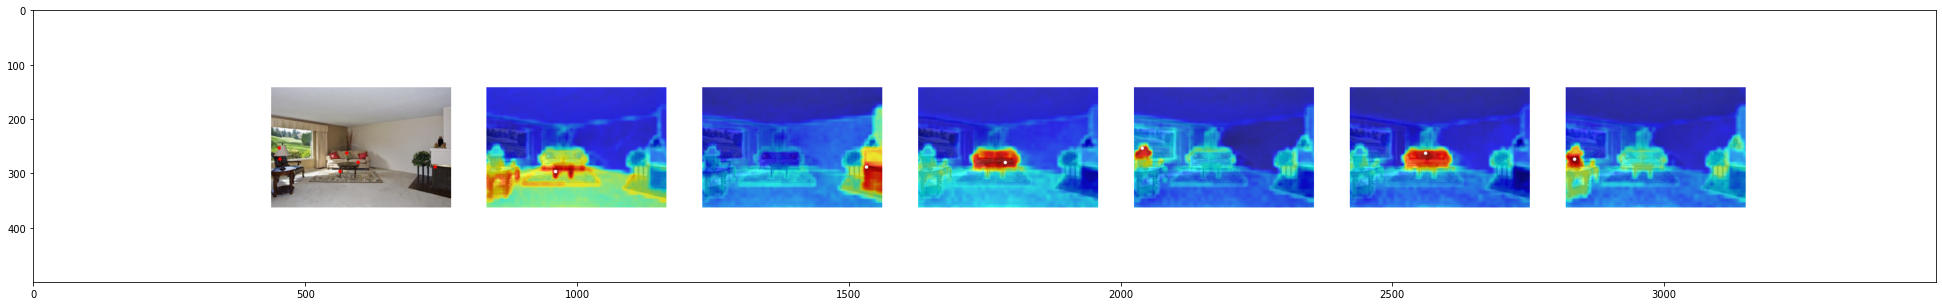

ADE_val_00000511 ['painting', 'radiator', 'sofa', 'armchair.png'] 0.47136617047525364


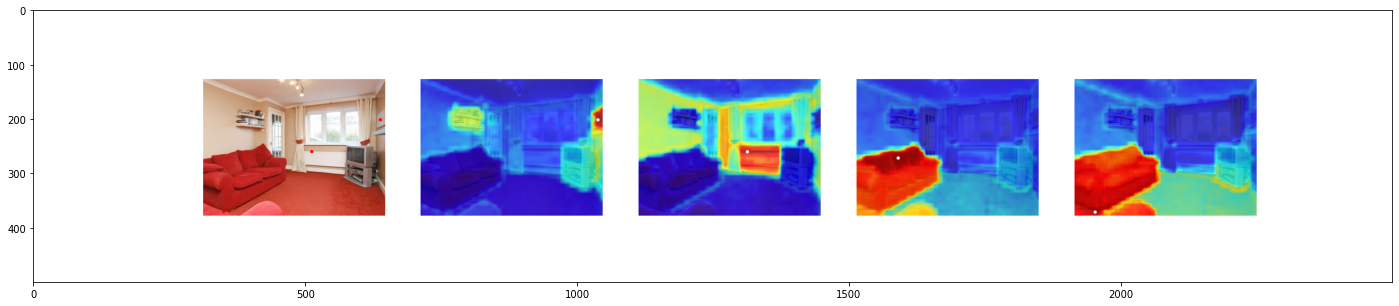

In [2]:
import mmcv
import numpy as np
import torch
from collections import OrderedDict
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt

vis_files = glob("../vis_dirs/baseline_c171_eval_a150_novel_only/*.png")
for f in vis_files:
    name = os.path.basename(f)[:len("ADE_val_00000003")]
    if image_ious[name] > 0.4 and "sofa" in f:
        print(name, os.path.basename(f)[len("ADE_val_00000003"):].split("_")[1:], image_ious[name])
        plt.figure(figsize=(50,5))
        plt.imshow(Image.open(f))
        plt.show()
        plt.close()

In [ ]:
# for f in files:
#     name = os.path.basename(f).rstrip(".png")
#     label = np.array(Image.open(
#         f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/annotations/val2017/{name}_labelTrainIds.png'
#     ))
#     if image_ious[name] > 0.8 and len(np.unique(label)) > 6:
#         print(len(np.unique(label)), name, image_ious[name])
#         img = Image.open(
#             f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/images/val2017/{name}.jpg'
#         )
#         plt.imshow(img)
#         plt.show()
#         plt.close()
